In [1]:
import pandas as pd
import pyspark.sql.functions as F
from datetime import datetime
from pyspark.sql.types import *

In [2]:
# dataviz
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS

<hr />

# srag 2019

<hr />

In [9]:
srag_2019 = spark.read.csv('gs://ai-covid19-datalake/raw/srag/2019/srag_2019.csv', inferSchema=True, header=True, sep=';')

## about the columns

In [4]:
srag_2019.limit(5).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO
0,10/01/2019,2,06/01/2019,2,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620,UNIDADE DE PRONTO ATENDIMENTO LESTE,...,14/03/2019,0,None,None,None,None,None,None,None,None
1,03/01/2019,1,01/01/2019,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HOSP MUN M BOI MIRIM,...,None,0,None,None,None,None,None,None,None,None
2,02/01/2019,1,31/12/2018,1,PE,1,1497,RECIFE,261160,IMIP,...,None,0,None,None,None,None,None,None,None,None
3,10/01/2019,2,07/01/2019,2,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950,HOSPITAL MUNICIPAL DR MARIO GATTI CAMPINAS,...,None,0,None,None,None,None,None,None,None,None
4,11/01/2019,2,06/01/2019,2,PE,4,1499,CARUARU,260410,SECRETARIA MUNICIPAL DE SAUDE DE CARUARU,...,None,0,None,None,None,None,None,None,None,None


In [43]:
# columns types according to srag dictionary
# date_type: 
date_type_columns = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_VGM', 'DT_RT_VGM', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 
                     'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_EVOLUCA', 'DT_DIGITA']


# location categorical cols:
location_cat_cols = ['SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'SG_UF', 'ID_MN_RESI', 'CO_MUN_RES',
                     'CS_ZONA', 'ID_PAIS', 'CO_PAIS', 'HISTO_VGM', 'PAIS_VGM', 'CO_PS_VGM', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE',
                     'ID_MN_INTE', 'CO_MU_INTE']

# semi identifiers 
semi_id_cat_cols = ['CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'PAC_COCBO', 'PAC_DSCBO', 'AVE_SUINO']


# symptoms
symptoms_cat_cols = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN']


# risk factor 
risk_factor_cat_cols = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 
                        'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI']
                                   


# case descriptors
case_desc_cat_cols = ['SURTO_SG', 'NOSOCOMIAL', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 
                      'RAIOX_RES', 'AMOSTRA', 'TP_AMOSTRA', 'IF_RESUL', 'POS_IF_FLU', 'TP_FLU_IF', 'POS_IF_OUT', 'LAB_IF', 'CO_LAB_IF',
                      'PCR_RESUL', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'PCR_FLUBLI', 'POS_PCROUT', 'LAB_PCR', 'CO_LAB_PCR',
                      'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO']



# varchar vars (could be id or numerical)
varchar_cols = ['NU_NOTIFIC', 'SEM_PRI', 'NU_IDADE_N', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC', 'OUT_ANTIV', 'RAIOX_OUT', 'OUT_AMOST', 'REQUI_GAL', 'DS_IF_OUT',
               'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'OBSERVA']




# ver 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC'
                                
                                
# Pontos de atencao: 
# Distancia entre primeiros sintomas e teste ('DT_PCR')
# Distancia entre primeiros sintomas e evolucao ('DT_EVOLUCA', 'DT_ENCERRA')

In [42]:
srag_2019.printSchema()

root
 |-- DT_NOTIFIC: date (nullable = true)
 |-- SEM_NOT: string (nullable = true)
 |-- DT_SIN_PRI: date (nullable = true)
 |-- SEM_PRI: string (nullable = true)
 |-- SG_UF_NOT: string (nullable = true)
 |-- ID_REGIONA: string (nullable = true)
 |-- CO_REGIONA: string (nullable = true)
 |-- ID_MUNICIP: string (nullable = true)
 |-- CO_MUN_NOT: string (nullable = true)
 |-- ID_UNIDADE: string (nullable = true)
 |-- CO_UNI_NOT: string (nullable = true)
 |-- CS_SEXO: string (nullable = true)
 |-- DT_NASC: date (nullable = true)
 |-- NU_IDADE_N: integer (nullable = true)
 |-- TP_IDADE: integer (nullable = true)
 |-- COD_IDADE: integer (nullable = true)
 |-- CS_GESTANT: integer (nullable = true)
 |-- CS_RACA: integer (nullable = true)
 |-- CS_ETINIA: string (nullable = true)
 |-- CS_ESCOL_N: integer (nullable = true)
 |-- ID_PAIS: string (nullable = true)
 |-- CO_PAIS: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CO_RG_RESI: integer (nullable = true)
 |-- ID_MN_RESI:

## Formatting data type variables

In [10]:
# some values on var 'DT_NOTIFIC' has strange values, such as:  "UTI 17/02/2019 04/03/2019" or "DATA INTERNACAO 28/4/19.  20/08/2019- PERMANECE INTERNADA"

# Converting to proper data type on pyspark
before_count = srag_2019.count()
print('Number of lines before date formatting: ', before_count)
for col in date_type_columns:
    srag_2019 = srag_2019.withColumn(col, F.to_date(F.col(col), 'dd/MM/yyyy'))
    if col == 'DT_NOTIFIC':
        srag_2019 = srag_2019.filter((F.year(col) != 18) & (F.year(col) != 19) & (F.year(col) != 20))

after_count = srag_2019.count()
print('Number of lines before date formatting: ', srag_2019.count())
total_count = before_count - after_count
print('A total of lines deleted: ', total_count)

Number of lines before date formatting:  50152
Number of lines before date formatting:  48554
A total of lines deleted:  1598


In [13]:
# Creating 'age' variable from the difference between date of birth and notification event
srag_2019 = srag_2019.withColumn("AGE_AT_NOTIF", F.datediff(F.col('DT_NOTIFIC'), F.col('DT_NASC'))/365.25)\
            .withColumn('AGE_AT_NOTIF', F.floor(F.col('AGE_AT_NOTIF')))

### some descriptions

<AxesSubplot:>

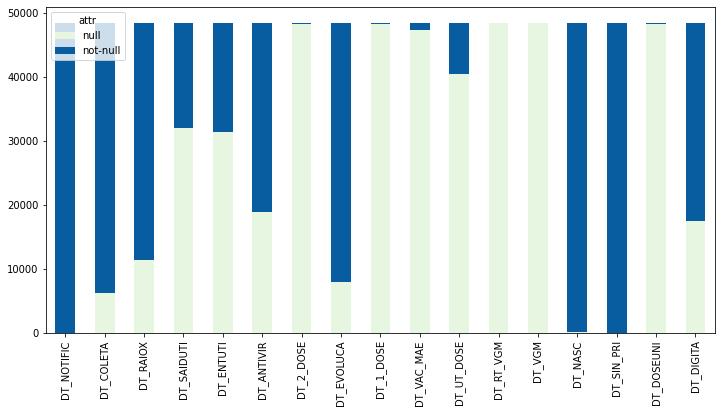

In [14]:
# quantifying nulls
pd_nulls_date_type_cols = srag_2019.select(date_type_columns)

# tagging nulls and not nulls values
for col in date_type_columns:
    pd_nulls_date_type_cols = pd_nulls_date_type_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_dates = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in date_type_columns:
    to_be_joined = pd_nulls_date_type_cols.select(col).groupby(col).count()
    null_dates = null_dates.join(to_be_joined, null_dates['attr'] == to_be_joined[col], 'left')
    null_dates = null_dates.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_dates = null_dates.withColumnRenamed('count', col)

null_dates = null_dates.toPandas()

# Plotting

null_dates.set_index('attr')\
  .reindex(null_dates.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:xlabel='AGE_AT_NOTIF', ylabel='Count'>

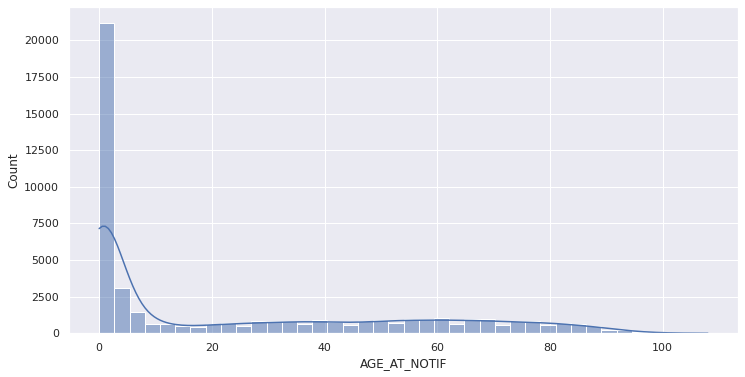

In [15]:
age_col = srag_2019.select(['AGE_AT_NOTIF', 'NU_IDADE_N']).toPandas()
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=age_col, x="AGE_AT_NOTIF", kde=True, palette="GnBu")

<AxesSubplot:xlabel='NU_IDADE_N', ylabel='Count'>

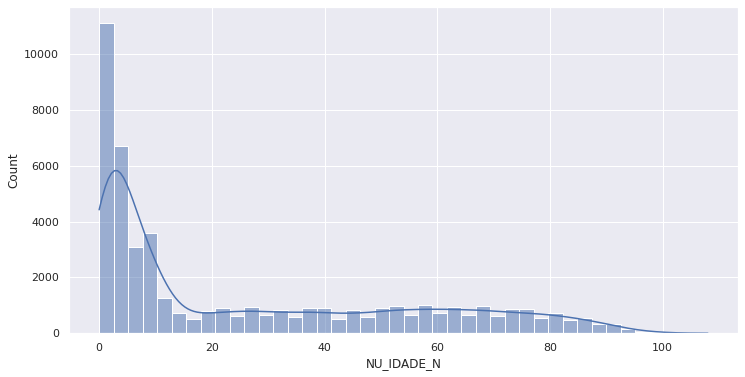

In [16]:
sns.histplot(data=age_col, x="NU_IDADE_N", kde=True, palette="gray")

In [12]:
# how much cases for year in 2019 srag 
srag_2019.select(F.year("DT_NOTIFIC")).groupBy('year(DT_NOTIFIC)').count().show()

+----------------+-----+
|year(DT_NOTIFIC)|count|
+----------------+-----+
|            2018|    3|
|            2019|48286|
|            2020|  265|
+----------------+-----+



<AxesSubplot:xlabel='DT_NOTIFIC', ylabel='count'>

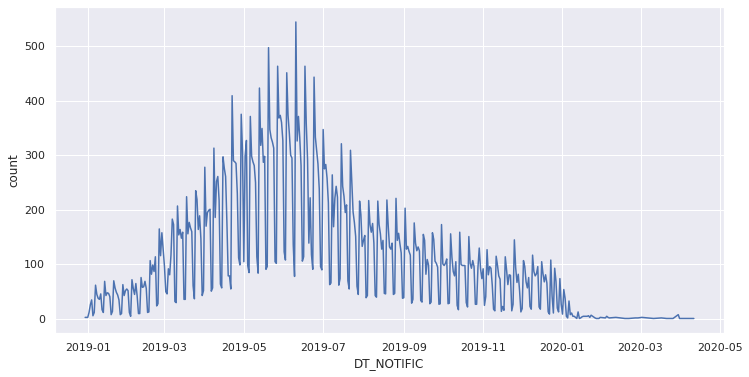

In [17]:
# how much cases for day
daily_cases = srag_2019.select('DT_NOTIFIC').groupby('DT_NOTIFIC').count().orderBy('DT_NOTIFIC').toPandas()
sns.lineplot(data=daily_cases, x="DT_NOTIFIC", y="count")

<AxesSubplot:xlabel='SEM_PRI', ylabel='count'>

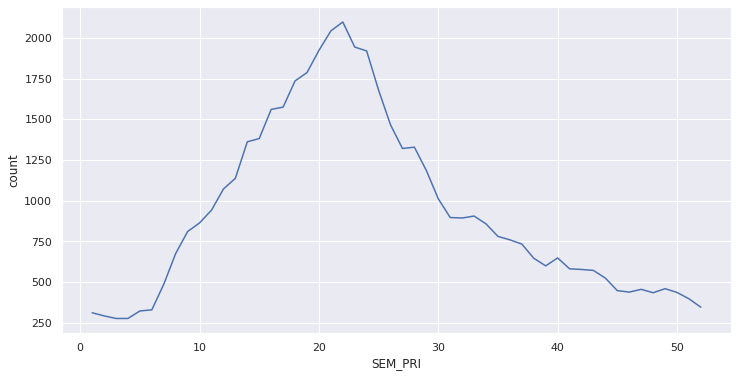

In [25]:
epi_week_cases = srag_2019.select('SEM_PRI').withColumn('SEM_PRI', srag_2019.SEM_PRI.cast(IntegerType()))\
                .groupby('SEM_PRI').count().orderBy('SEM_PRI')\
                .toPandas().dropna()
sns.lineplot(data=epi_week_cases, x="SEM_PRI", y="count")

[Text(0, 0, 'jan'),
 Text(1, 0, 'feb'),
 Text(2, 0, 'apr'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'may'),
 Text(5, 0, 'jun'),
 Text(6, 0, 'jul'),
 Text(7, 0, 'aug'),
 Text(8, 0, 'sep'),
 Text(9, 0, 'oct'),
 Text(10, 0, 'nov'),
 Text(11, 0, 'dec')]

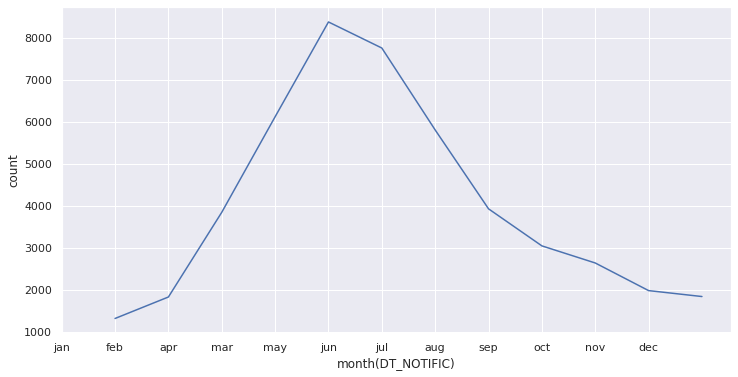

In [40]:
monthly_cases = srag_2019.select('DT_NOTIFIC').groupby(F.month('DT_NOTIFIC')).count().orderBy('month(DT_NOTIFIC)')\
                .toPandas().dropna()
g = sns.lineplot(data=monthly_cases, x="month(DT_NOTIFIC)", y="count")
g.set_xticks(range(len(monthly_cases)))
g.set_xticklabels(['jan','feb','apr','mar','may','jun','jul','aug', 'sep', 'oct', 'nov', 'dec'])

## formating location variables

### some descriptions

In [48]:
srag_2019.select(location_cat_cols).limit(10).toPandas()

,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,ID_REGIONA,CO_REGIONA,SG_UF,ID_MN_RESI,CO_MUN_RES,CS_ZONA,ID_PAIS,CO_PAIS,HISTO_VGM,PAIS_VGM,CO_PS_VGM,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE
0,MG,BELO HORIZONTE,310620,BELO HORIZONTE,1449,MG,RIBEIRAO DAS NEVES,315460,1,BRASIL,1,0,None,None,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620
1,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,1,BRASIL,1,0,None,None,SP,GVE I CAPITAL,1331,SAO PAULO,355030
2,PE,RECIFE,261160,1,1497,PE,GOIANA,260620,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
3,SP,CAMPINAS,350950,GVE XVII CAMPINAS,1342,SP,CAMPINAS,350950,1,BRASIL,1,0,None,None,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950
4,PE,CARUARU,260410,4,1499,PE,BELO JARDIM,260170,1,BRASIL,1,0,None,None,PE,4,1499,CARUARU,260410
5,PE,RECIFE,261160,1,1497,PE,RECIFE,261160,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
6,MS,CAMPO GRANDE,500270,EX ARS DE CAMPO GRANDE,1975,MS,CAMPO GRANDE,500270,1,BRASIL,1,0,None,None,MS,EX ARS DE CAMPO GRANDE,1975,CAMPO GRANDE,500270
7,PE,RECIFE,261160,1,1497,PE,OLINDA,260960,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
8,PE,RECIFE,261160,1,1497,PE,RECIFE,261160,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
9,PE,RECIFE,261160,1,1497,PE,IPOJUCA,260720,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160


In [54]:
# how much notification occurred in a municipallity far from patient's residence
srag_2019.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .groupBy('DIFF_MUN').count().show()

+--------------+-----+
|      DIFF_MUN|count|
+--------------+-----+
|DIFFERENT CITY|15601|
|     SAME CITY|32953|
+--------------+-----+



In [55]:
# which state exported more notifications to other cities (in or out the same state)
srag_2019.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .filter(F.col('DIFF_MUN') == 'DIFFERENT CITY').groupBy('SG_UF').count().show()

+-----+-----+
|SG_UF|count|
+-----+-----+
|   SC|  835|
|   RO|   74|
|   PI|  118|
|   AM|  224|
|   RR|    7|
|   GO|  702|
| null|   63|
|   TO|   98|
|   MT|  106|
|   SP| 2835|
|   PB|  162|
|   ES|  409|
|   RS| 1035|
|   MS|  286|
|   AL|   73|
|   MG| 1266|
|   PA|  252|
|   BA|  465|
|   SE|  118|
|   PE| 1494|
+-----+-----+
only showing top 20 rows



<AxesSubplot:>

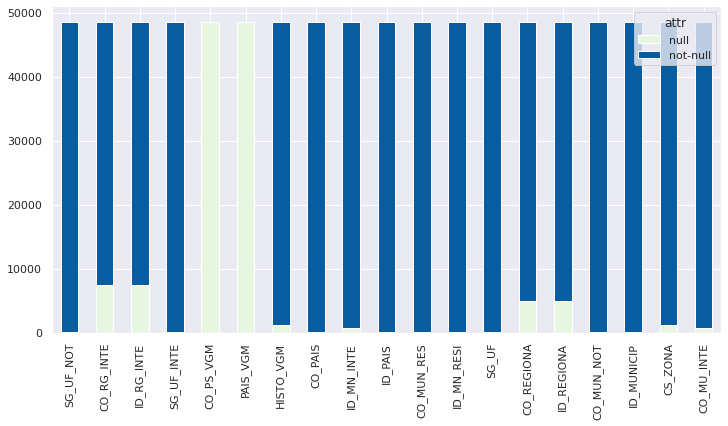

In [47]:
# quantifying nulls
pd_nulls_location_cat_cols = srag_2019.select(location_cat_cols)

# tagging nulls and not nulls values
for col in location_cat_cols:
    pd_nulls_location_cat_cols = pd_nulls_location_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_loc = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in location_cat_cols:
    to_be_joined = pd_nulls_location_cat_cols.select(col).groupby(col).count()
    null_loc = null_loc.join(to_be_joined, null_loc['attr'] == to_be_joined[col], 'left')
    null_loc = null_loc.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_loc = null_loc.withColumnRenamed('count', col)

null_loc = null_loc.toPandas()

# Plotting

null_loc.set_index('attr')\
  .reindex(null_loc.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formating id vars

### some descriptions

<AxesSubplot:>

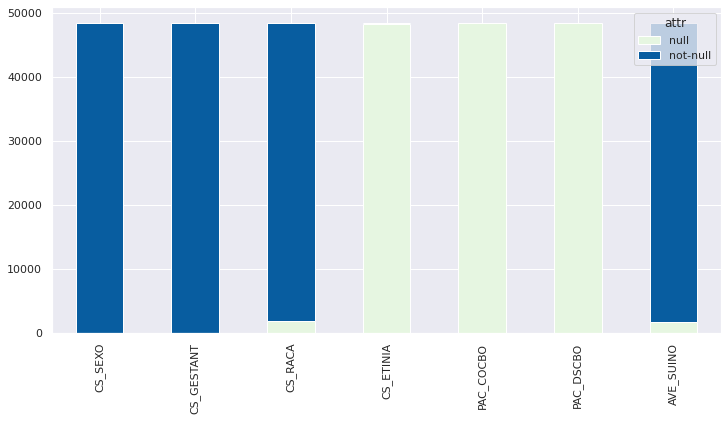

In [62]:
# quantifying nulls
pd_nulls_semi_id_cat_cols = srag_2019.select(semi_id_cat_cols)

# tagging nulls and not nulls values
for col in semi_id_cat_cols:
    pd_nulls_semi_id_cat_cols = pd_nulls_semi_id_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_id = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in semi_id_cat_cols:
    to_be_joined = pd_nulls_semi_id_cat_cols.select(col).groupby(col).count()
    null_id = null_id.join(to_be_joined, null_id['attr'] == to_be_joined[col], 'left')
    null_id = null_id.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_id = null_id.withColumnRenamed('count', col)

null_id = null_id.toPandas()

# Plotting

null_id.set_index('attr')\
  .reindex(null_id.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formatting symptoms variables 

In [64]:
srag_2019.select(symptoms_cat_cols).limit(10).toPandas()

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN
0,1,1,2,1,1,1,2,2,1
1,1,1,2,1,1,1,2,2,2
2,1,1,2,1,1,1,2,2,2
3,1,1,9,1,1,1,2,2,2
4,1,2,2,1,1,1,9,9,2
5,1,1,2,1,1,1,2,2,1
6,1,1,2,1,1,1,2,2,2
7,1,1,2,1,1,1,2,2,2
8,1,1,2,1,1,2,1,1,1
9,1,1,2,1,1,2,2,2,2


### some descriptions

<AxesSubplot:>

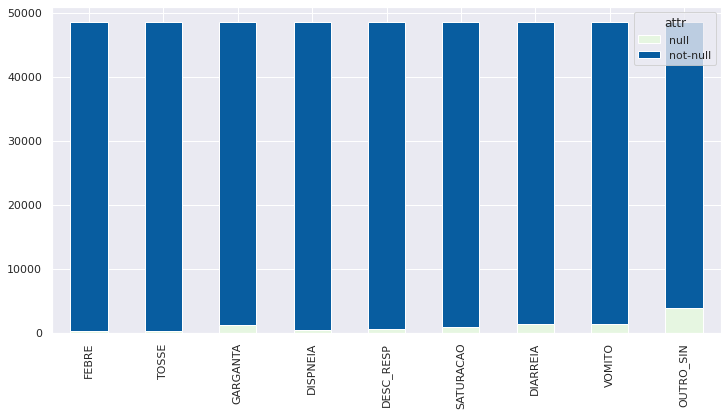

In [63]:
# quantifying nulls
pd_nulls_symptoms_cat_cols = srag_2019.select(symptoms_cat_cols)

# tagging nulls and not nulls values
for col in symptoms_cat_cols:
    pd_nulls_symptoms_cat_cols = pd_nulls_symptoms_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_symp = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in symptoms_cat_cols:
    to_be_joined = pd_nulls_symptoms_cat_cols.select(col).groupby(col).count()
    null_symp = null_symp.join(to_be_joined, null_symp['attr'] == to_be_joined[col], 'left')
    null_symp = null_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_symp = null_symp.withColumnRenamed('count', col)

null_symp = null_symp.toPandas()

# Plotting

null_symp.set_index('attr')\
  .reindex(null_symp.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

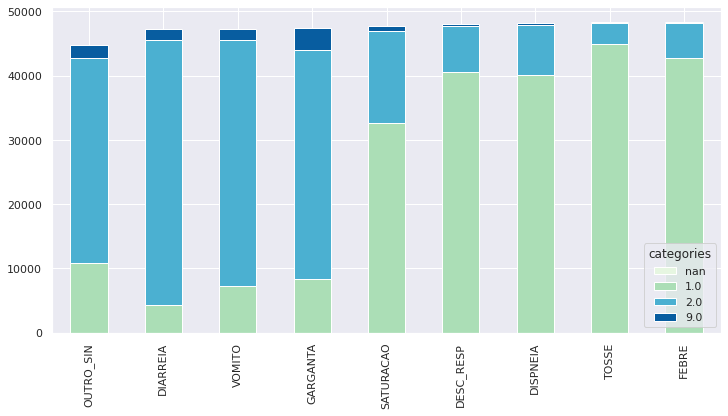

In [83]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
pd_symptoms_cat_cols = srag_2019.select(symptoms_cat_cols)
categories_symp = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in symptoms_cat_cols: 
    to_be_joined = pd_symptoms_cat_cols.select(col).groupby(col).count()
    categories_symp = categories_symp.join(to_be_joined, categories_symp['categories'] == to_be_joined[col], 'left')
    categories_symp = categories_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_symp = categories_symp.withColumnRenamed('count', col)

categories_symp = categories_symp.toPandas()

# Plotting

categories_symp.set_index('categories')\
  .reindex(categories_symp.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  10916


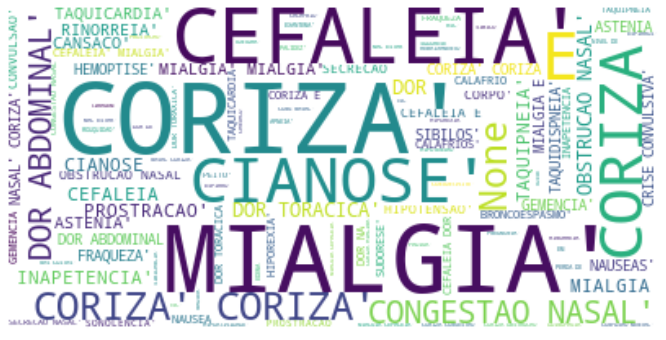

In [107]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_symp_to_wc = srag_2019.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').count())

#Final word cloud after all the cleaning and pre-processing
text = another_symp_to_wc['OUTRO_DES'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting risk factor variables 

In [109]:
srag_2019.select(risk_factor_cat_cols).limit(10).toPandas()

,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None


### some descriptions

<AxesSubplot:>

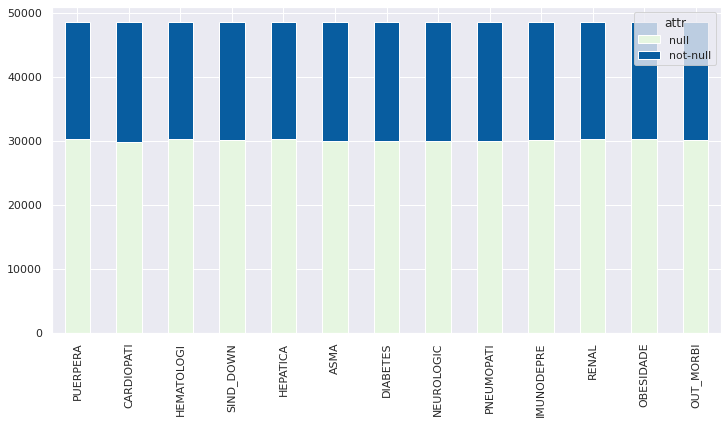

In [108]:
# quantifying nulls
pd_nulls_risk_factor_cat_cols = srag_2019.select(risk_factor_cat_cols)

# tagging nulls and not nulls values
for col in risk_factor_cat_cols:
    pd_nulls_risk_factor_cat_cols = pd_nulls_risk_factor_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_risk = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in risk_factor_cat_cols:
    to_be_joined = pd_nulls_risk_factor_cat_cols.select(col).groupby(col).count()
    null_risk = null_risk.join(to_be_joined, null_risk['attr'] == to_be_joined[col], 'left')
    null_risk = null_risk.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_risk = null_risk.withColumnRenamed('count', col)

null_risk = null_risk.toPandas()

# Plotting

null_risk.set_index('attr')\
  .reindex(null_risk.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

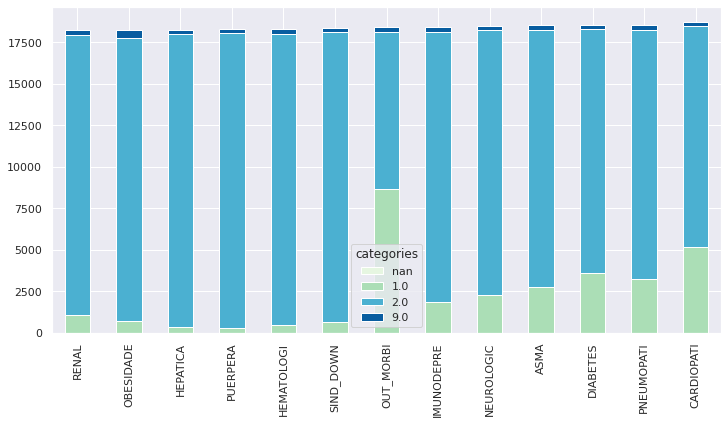

In [116]:
# how distributed are the risk factors
pd_risk_factor = srag_2019.select(risk_factor_cat_cols)
categories_risk_factor = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in risk_factor_cat_cols: 
    to_be_joined = pd_risk_factor.select(col).groupby(col).count()
    categories_risk_factor = categories_risk_factor.join(to_be_joined, categories_risk_factor['categories'] == to_be_joined[col], 'left')
    categories_risk_factor = categories_risk_factor.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_risk_factor = categories_risk_factor.withColumnRenamed('count', col)

categories_risk_factor = categories_risk_factor.toPandas()

# Plotting

categories_risk_factor.set_index('categories')\
  .reindex(categories_risk_factor.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  8651


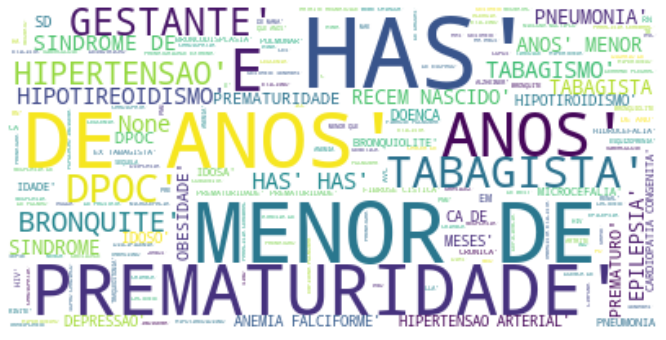

In [119]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_risk_factor_to_wc = srag_2019.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').count())

#Final word cloud after all the cleaning and pre-processing

text = another_risk_factor_to_wc['MORB_DESC'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()